In [1]:
# this is my compatition try to understand using GIT

In [2]:
# Document Change

In [3]:
# I do a change that i will not like it

In [4]:
# i create a new branch name feature/login

In [5]:
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from pathlib import Path
from sklearn import preprocessing
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import lightgbm as lgb
import catboost as cb
import xgboost as xgb
from sklearn.base import clone
import joblib 
import warnings
warnings.filterwarnings("ignore")

In [6]:
N_FOLDS = 5
ALPHA = 0.1 # for using as the covarage (means 90%) in winkler_score
HILL_CLIMB_STEPS = 500
MODEL_NAMES = ["LightGBM", "CatBoost", "XGBoost"]
INITIAL_WEIGHTS = [0.4, 0.3, 0.3]

In [7]:
train_path="dataset.csv"
test_path="test.csv"

train_df = pd.read_csv(train_path)
test     = pd.read_csv(test_path)

In [8]:
train_df.head()

,id,sale_date,sale_price,sale_nbr,sale_warning,join_status,join_year,latitude,longitude,area,...,view_olympics,view_cascades,view_territorial,view_skyline,view_sound,view_lakewash,view_lakesamm,view_otherwater,view_other,submarket
0,0,2014-11-15,236000,2.0,,nochg,2025,47.2917,-122.3658,53,...,0,0,0,0,0,0,0,0,0,I
1,1,1999-01-15,313300,NaN,26,nochg,2025,47.6531,-122.1996,74,...,0,0,0,0,0,1,0,0,0,Q
2,2,2006-08-15,341000,1.0,,nochg,2025,47.4733,-122.1901,30,...,0,0,0,0,0,0,0,0,0,K
3,3,1999-12-15,267000,1.0,,nochg,2025,47.4739,-122.3295,96,...,0,0,0,0,0,0,0,0,0,G
4,4,2018-07-15,1650000,2.0,,miss99,2025,47.7516,-122.1222,36,...,0,0,0,0,0,0,0,0,0,P


In [9]:
train_df.shape

(200000, 47)

In [10]:
train_df.describe()

,id,sale_price,sale_nbr,join_year,latitude,longitude,area,present_use,land_val,imp_val,...,view_rainier,view_olympics,view_cascades,view_territorial,view_skyline,view_sound,view_lakewash,view_lakesamm,view_otherwater,view_other
count,200000.000000,2.000000e+05,157818.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,2.000000e+05,2.000000e+05,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,99999.500000,5.841495e+05,2.162599,2023.403600,47.549248,-122.210416,48.644215,4.108860,4.601691e+05,4.917715e+05,...,0.017940,0.053985,0.058800,0.215550,0.018425,0.055565,0.050075,0.014090,0.020875,0.013455
std,57735.171256,4.170595e+05,1.113090,6.241643,0.142710,0.140339,27.132002,7.199323,3.510444e+05,3.680505e+05,...,0.218994,0.379119,0.381868,0.724224,0.222746,0.380011,0.353664,0.200154,0.248977,0.181147
min,0.000000,5.029300e+04,1.000000,1999.000000,47.155200,-122.527700,1.000000,2.000000,0.000000e+00,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,49999.750000,3.050000e+05,1.000000,2025.000000,47.446500,-122.323800,26.000000,2.000000,2.310000e+05,2.800000e+05,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,99999.500000,4.599500e+05,2.000000,2025.000000,47.562800,-122.222700,48.000000,2.000000,3.770000e+05,4.090000e+05,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,149999.250000,7.249500e+05,3.000000,2025.000000,47.673500,-122.121700,71.000000,2.000000,5.940000e+05,5.990000e+05,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,199999.000000,2.999950e+06,11.000000,2025.000000,47.777800,-121.161300,100.000000,29.000000,1.386400e+07,1.006700e+07,...,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000


## Droping high-missing fields

In [11]:
train_df.drop(columns=["submarket","subdivision","sale_nbr"], inplace=True)
test.drop(columns=["submarket","subdivision","sale_nbr"], inplace=True)

In [12]:
train_df.shape

(200000, 44)

## Data Preprocessing & Feature Engineering 

In [13]:
train_df.dtypes

id                    int64
sale_date            object
sale_price            int64
sale_warning         object
join_status          object
join_year             int64
latitude            float64
longitude           float64
area                  int64
city                 object
zoning               object
present_use           int64
land_val              int64
imp_val               int64
year_built            int64
year_reno             int64
sqft_lot              int64
sqft                  int64
sqft_1                int64
sqft_fbsmt            int64
grade                 int64
fbsmt_grade           int64
condition             int64
stories             float64
beds                  int64
bath_full             int64
bath_3qtr             int64
bath_half             int64
garb_sqft             int64
gara_sqft             int64
wfnt                  int64
golf                  int64
greenbelt             int64
noise_traffic         int64
view_rainier          int64
view_olympics       

In [14]:
def preprocess(df):
    df['sale_date'] = pd.to_datetime(df['sale_date'])
    df['sale_year'] = df['sale_date'].dt.year
    df['sale_month'] = df['sale_date'].dt.month
    df['age'] = df['sale_year']- df['year_built']
    df['renovated'] =np.where(df['year_reno']>0, 1 , 0)
    df['years_since_reno'] = np.where(df['year_reno']>0, df['sale_year'] - df['year_reno'] , 0)
    df['total_baths'] = df['bath_full'] + 0.75*df['bath_3qtr'] + 0.5*df['bath_half']
    df['total_value'] = df['land_val'] + df['imp_val']
    df['living_area'] = df['sqft'] + df['sqft_fbsmt']

    # Encode categoricals (simplified example)
    cat_cols = ['sale_warning', 'join_status', 'city', 'zoning']
    for col in cat_cols:
        df[col] = df[col].astype('category')

    return df.drop(columns=['sale_date', 'id'])

# Load and preprocess data
train_df = preprocess(train_df)
X_test = preprocess(test)

## Feature-Target Split & Ordinal Encoding 

In [15]:
train_df['zoning'].value_counts()

zoning
NR3           28800
R6            18728
R4            11031
RA5            8397
NR2            7165
              ...  
M                 1
RM 50             1
RM 3.6 (2)        1
MB                1
RM-1800           1
Name: count, Length: 500, dtype: int64

In [16]:
train_df['zoning'].isnull().sum()

0

In [17]:
X = train_df.drop(columns=['sale_price'])
y = train_df['sale_price']

In [18]:
X.shape

(200000, 49)

In [19]:
X.columns

Index(['sale_warning', 'join_status', 'join_year', 'latitude', 'longitude',
       'area', 'city', 'zoning', 'present_use', 'land_val', 'imp_val',
       'year_built', 'year_reno', 'sqft_lot', 'sqft', 'sqft_1', 'sqft_fbsmt',
       'grade', 'fbsmt_grade', 'condition', 'stories', 'beds', 'bath_full',
       'bath_3qtr', 'bath_half', 'garb_sqft', 'gara_sqft', 'wfnt', 'golf',
       'greenbelt', 'noise_traffic', 'view_rainier', 'view_olympics',
       'view_cascades', 'view_territorial', 'view_skyline', 'view_sound',
       'view_lakewash', 'view_lakesamm', 'view_otherwater', 'view_other',
       'sale_year', 'sale_month', 'age', 'renovated', 'years_since_reno',
       'total_baths', 'total_value', 'living_area'],
      dtype='object')

In [20]:
# Ordinal encoding.
cat_cols = ['sale_warning', 'join_status', 'city', 'zoning']
enconder = OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1)

In [21]:
X[cat_cols] = enconder.fit_transform(X[cat_cols])

In [22]:
X['zoning'].describe()

count    200000.000000
mean        295.817690
std         103.287725
min           0.000000
25%         210.000000
50%         299.000000
75%         352.000000
max         499.000000
Name: zoning, dtype: float64

In [23]:
X_test[cat_cols] = enconder.transform(X_test[cat_cols])

In [24]:
X.describe()

,sale_warning,join_status,join_year,latitude,longitude,area,city,zoning,present_use,land_val,...,view_otherwater,view_other,sale_year,sale_month,age,renovated,years_since_reno,total_baths,total_value,living_area
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,2.000000e+05,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.00000,200000.000000,200000.000000,200000.000000,2.000000e+05,200000.000000
mean,7.329180,2.876155,2023.403600,47.549248,-122.210416,48.644215,22.792535,295.817690,4.108860,4.601691e+05,...,0.020875,0.013455,2011.186940,6.626605,37.00218,0.029800,0.515630,2.196831,9.519406e+05,2413.918385
std,25.320128,1.051529,6.241643,0.142710,0.140339,27.132002,10.645815,103.287725,7.199323,3.510444e+05,...,0.248977,0.181147,7.595524,3.153977,30.97995,0.170036,3.983286,0.761216,5.977096e+05,1157.314211
min,0.000000,0.000000,1999.000000,47.155200,-122.527700,1.000000,0.000000,0.000000,2.000000,0.000000e+00,...,0.000000,0.000000,1999.000000,1.000000,-26.00000,0.000000,-23.000000,0.000000,0.000000e+00,0.000000
25%,0.000000,2.000000,2025.000000,47.446500,-122.323800,26.000000,17.000000,210.000000,2.000000,2.310000e+05,...,0.000000,0.000000,2004.000000,4.000000,9.00000,0.000000,0.000000,1.750000,5.980000e+05,1560.000000
50%,0.000000,3.000000,2025.000000,47.562800,-122.222700,48.000000,23.000000,299.000000,2.000000,3.770000e+05,...,0.000000,0.000000,2012.000000,7.000000,33.00000,0.000000,0.000000,2.250000,8.060000e+05,2240.000000
75%,0.000000,3.000000,2025.000000,47.673500,-122.121700,71.000000,33.000000,352.000000,2.000000,5.940000e+05,...,0.000000,0.000000,2018.000000,9.000000,59.00000,0.000000,0.000000,2.500000,1.166000e+06,3030.000000
max,141.000000,7.000000,2025.000000,47.777800,-121.161300,100.000000,40.000000,499.000000,29.000000,1.386400e+07,...,4.000000,4.000000,2025.000000,12.000000,125.00000,1.000000,86.000000,11.750000,1.693700e+07,17670.000000


In [25]:
X.head()

,sale_warning,join_status,join_year,latitude,longitude,area,city,zoning,present_use,land_val,...,view_otherwater,view_other,sale_year,sale_month,age,renovated,years_since_reno,total_baths,total_value,living_area
0,0.0,3.0,2025,47.2917,-122.3658,53,13.0,417.0,2,167000,...,0,0,2014,11,39,0,0,1.75,539000,1560
1,71.0,3.0,2025,47.6531,-122.1996,74,19.0,402.0,2,1184000,...,0,0,1999,1,37,0,0,2.25,1782000,2860
2,0.0,3.0,2025,47.4733,-122.1901,30,30.0,283.0,2,230000,...,0,0,2006,8,20,0,0,2.50,586000,1640
3,0.0,3.0,2025,47.4739,-122.3295,96,6.0,407.0,2,190000,...,0,0,1999,12,1,0,0,2.50,708000,3110
4,0.0,1.0,2025,47.7516,-122.1222,36,18.0,348.0,2,616000,...,0,0,2018,7,20,0,0,3.25,2533000,4040


In [26]:
X.dtypes

sale_warning        float64
join_status         float64
join_year             int64
latitude            float64
longitude           float64
area                  int64
city                float64
zoning              float64
present_use           int64
land_val              int64
imp_val               int64
year_built            int64
year_reno             int64
sqft_lot              int64
sqft                  int64
sqft_1                int64
sqft_fbsmt            int64
grade                 int64
fbsmt_grade           int64
condition             int64
stories             float64
beds                  int64
bath_full             int64
bath_3qtr             int64
bath_half             int64
garb_sqft             int64
gara_sqft             int64
wfnt                  int64
golf                  int64
greenbelt             int64
noise_traffic         int64
view_rainier          int64
view_olympics         int64
view_cascades         int64
view_territorial      int64
view_skyline        

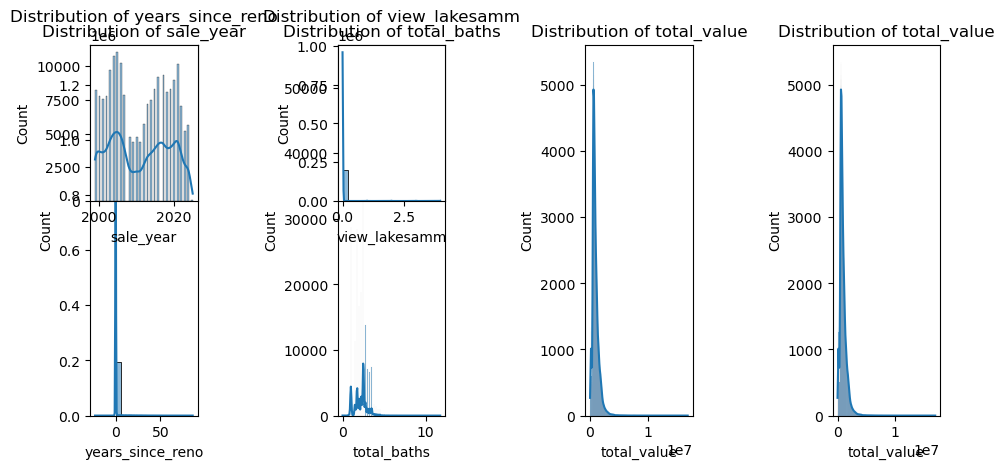

In [71]:

import seaborn as sns
import matplotlib.pyplot as plt

# List of numeric features you want to visualize
features = ['years_since_reno', 'total_baths', 'total_value','total_value','sale_year','view_lakesamm']  # replace with your column names


# Set up the plot grid
plt.figure(figsize=(15, 5))  # width, height in inches

for i, feature in enumerate(features):
    plt.subplot(int(i/4)+1, len(features), i%4 + 1)  # 1 row, N columns
    sns.histplot(X[feature], kde=True)  # kde=True adds the density curve
    plt.title(f'Distribution of {feature}')

plt.tight_layout()
plt.show()

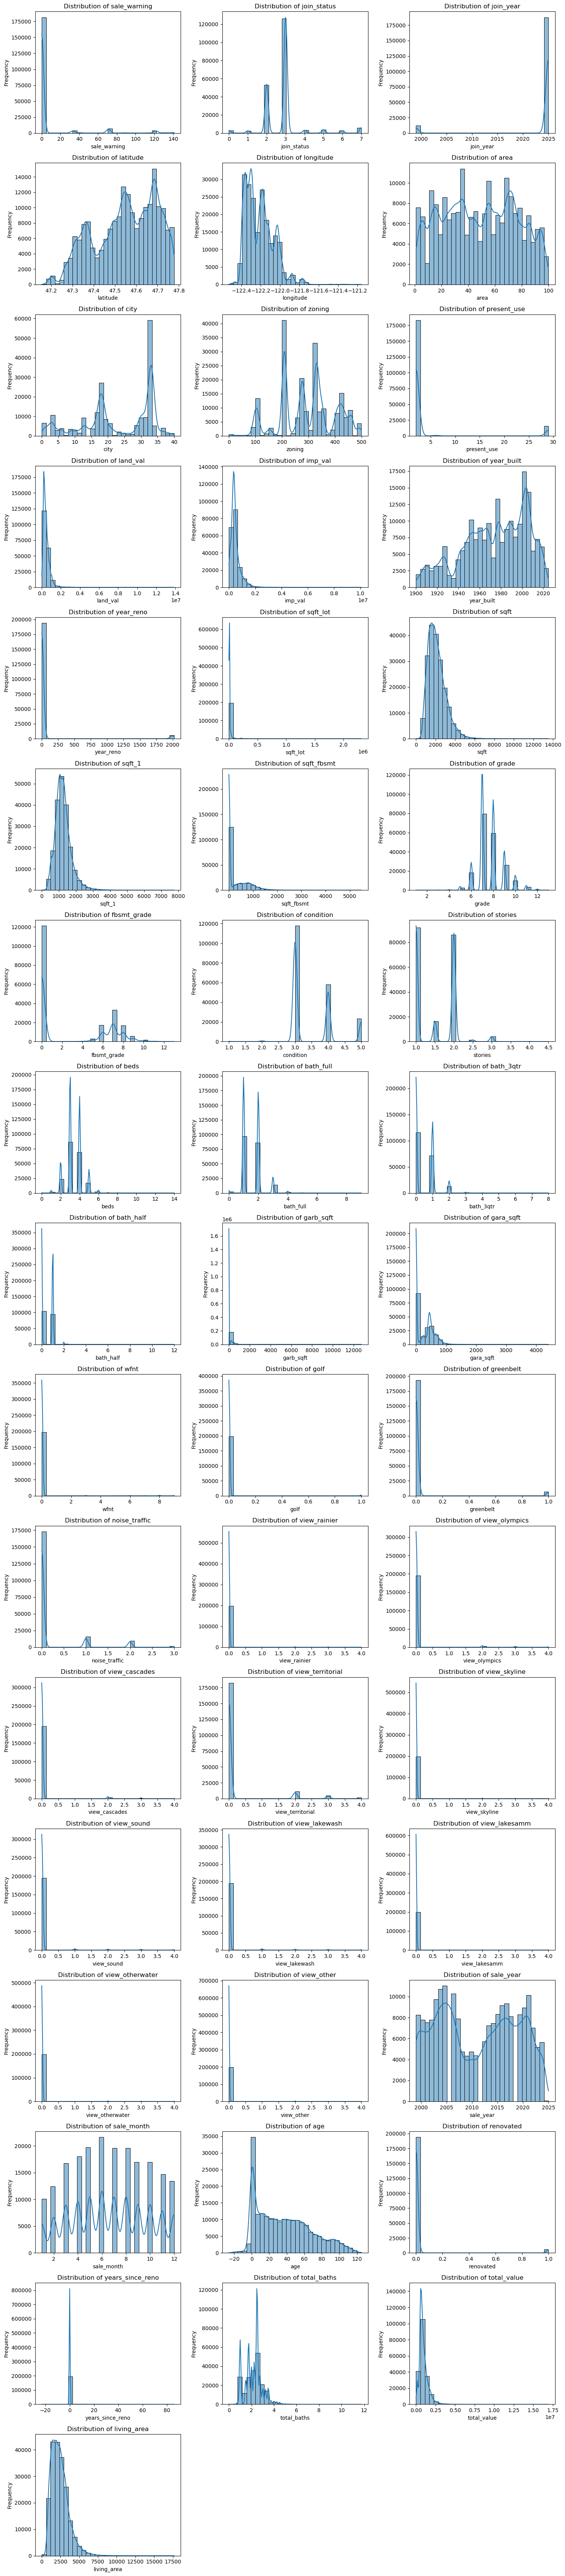

In [72]:
df = X.copy()
# Select only numerical columns
numerical_cols = df.select_dtypes(include=['number']).columns

# Set up the plot grid
n_cols = 3  # number of plots per row
n_rows = (len(numerical_cols) + n_cols - 1) // n_cols  # automatic row count
plt.figure(figsize=(n_cols * 5, n_rows * 4))

# Plot each feature
for idx, col in enumerate(numerical_cols, 1):
    plt.subplot(n_rows, n_cols, idx)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [28]:
sampled_ln = np.log10(X['total_value'])

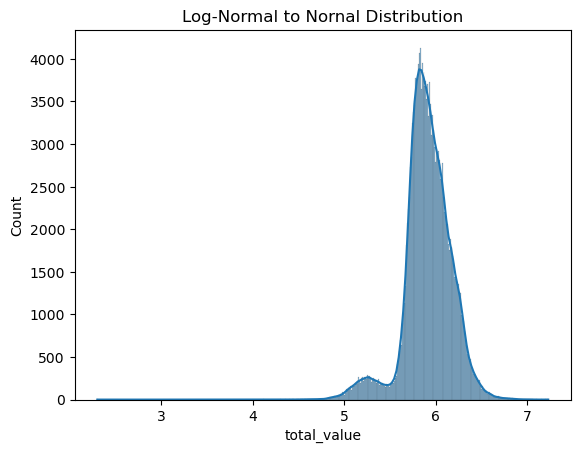

In [29]:
import seaborn as sns

sns.histplot(sampled_ln, kde=True)
plt.title("Log-Normal to Nornal Distribution")
plt.show()

In [64]:
np.array(np.maximum(sampled_ln,0))

array([5.73158877, 6.2509077 , 5.76789762, ..., 5.85551916, 6.0685569 ,
       5.8591383 ])

In [35]:
type(np.array(sampled_ln))

numpy.ndarray

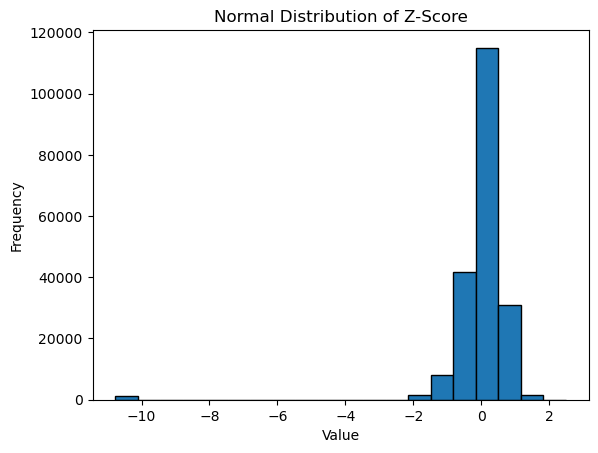

In [67]:
import scipy.stats as stats
look = np.array(np.maximum(sampled_ln,0))
z_scores = stats.zscore(look)

# Create histogram
plt.hist(z_scores, bins=20, edgecolor='black')

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Normal Distribution of Z-Score')

# Show plot
plt.show()

## Interval Scoring & Model Training Functions

In [20]:
def winkler_score(y_true, lower, upper, alpha=ALPHA):
    width = upper - lower
    below = np.maximum(lower - y_true, 0)
    above = np.maximum(y_true - upper, 0)
    return width + (2/alpha)*(below + above)

In [21]:
models = {
        "LightGBM": {
            "lower": lgb.LGBMRegressor(
                objective="quantile", 
                alpha=0.05,
                device="gpu",
                n_estimators=1500,
                learning_rate=0.05,
                num_leaves=63,
                subsample=0.8,
                subsample_freq=1,
                random_state=42
            ),
            "upper": lgb.LGBMRegressor(
                objective="quantile", 
                alpha=0.95,
                device="gpu",
                n_estimators=1500,
                learning_rate=0.05,
                num_leaves=63,
                subsample=0.8,
                subsample_freq=1,
                random_state=42
            )
        },
        "CatBoost": cb.CatBoostRegressor(
            loss_function="RMSEWithUncertainty",
            task_type="GPU",
            iterations=1500,
            learning_rate=0.05,
            depth=8,
            verbose=0,
            random_seed=42
        ),
        "XGBoost": {
            "lower": xgb.XGBRegressor(
                objective="reg:quantileerror", 
                quantile_alpha=0.05,
                tree_method="gpu_hist",
                n_estimators=1500,
                learning_rate=0.05,
                max_depth=8,
                subsample=0.8,
                random_state=42
            ),
            "upper": xgb.XGBRegressor(
                objective="reg:quantileerror", 
                quantile_alpha=0.95,
                tree_method="gpu_hist",
                n_estimators=1500,
                learning_rate=0.05,
                max_depth=8,
                subsample=0.8,
                random_state=42
            )
        }
    }
     
   

In [22]:
def train_model(model, X_train, y_train, X_val):
    model.fit(X_train, y_train)
    if isinstance(model, cb.CatBoostRegressor):
        preds = model.predict(X_val)
        means = preds[:, 0]
        stds = np.sqrt(preds[:, 1])
        lower = means - 1.645 * stds
        upper = means + 1.645 * stds
    else:
        lower = model["lower"].predict(X_val)
        upper = model["upper"].predict(X_val)
    return lower, upper      
        

In [23]:
model = cb.CatBoostRegressor

In [24]:
fitted = model(
            loss_function="RMSEWithUncertainty",
            task_type="GPU",
            iterations=1500,
            learning_rate=0.05,
            depth=8,
            verbose=0,
            random_seed=42
        ).fit(X,y)

In [25]:
t =X.head(2)

In [26]:
model = models['LightGBM']['lower']

In [27]:
#fitted = model.fit(X,y)

In [28]:
oof_lowers= {model: np.zeros(len(X)) for model in MODEL_NAMES}

In [29]:
oof_uppers= {model: np.zeros(len(X)) for model in MODEL_NAMES}

In [30]:
kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

In [31]:
for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Train and predict for each model
    for model_name in MODEL_NAMES:
        if model_name == "CatBoost":
            model = clone(models["CatBoost"])
            model.fit(X_train, y_train)
            preds = model.predict(X_val)
            means = preds[:, 0]
            stds = np.sqrt(preds[:, 1])
            oof_lowers[model_name][val_index] = means - 1.645 * stds
            oof_uppers[model_name][val_index] = means + 1.645 * stds
                
        else:
            # Train lower quantile model
            lower_model = clone(models[model_name]["lower"])
            lower_model.fit(X_train, y_train)
            lower_pred = lower_model.predict(X_val)
                
            # Train upper quantile model
            upper_model = clone(models[model_name]["upper"])
            upper_model.fit(X_train, y_train)
            upper_pred = upper_model.predict(X_val)
                
            oof_lowers[model_name][val_index] = lower_pred
            oof_uppers[model_name][val_index] = upper_pred






  File "D:\anaconda\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "D:\anaconda\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\anaconda\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "D:\anaconda\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4041
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 49
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4050 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (4.27 MB) transferred to GPU in 0.005546 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 185000.000000
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4041
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 49
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4050 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of 

In [57]:
model_scores = {}
print("\nModel Performance Evaluation:")

for model_name in MODEL_NAMES:
    lowers = np.minimum(oof_lowers[model_name] , oof_uppers[model_name])
    uppers = np.maximum(oof_lowers[model_name] , oof_uppers[model_name])

    model_scores[model_name] = np.mean(winkler_score(y, lowers, uppers))

    mwis = model_scores[model_name]
    model_scores[model_name] = mwis
    
    coverage = np.mean((y >= lowers) & (y <= uppers))*100
    print(f'the coverage of the model {model_name} is {coverage}% ,  MWIS = {mwis:.2f}')


Model Performance Evaluation:
the coverage of the model LightGBM is 83.58449999999999% ,  MWIS = 340516.71
the coverage of the model CatBoost is 87.8785% ,  MWIS = 348325.03
the coverage of the model XGBoost is 85.6765% ,  MWIS = 348202.01


In [48]:
    # Hill Climbing Optimization
print("\nStarting Hill Climbing Optimization...")
current_weights = np.array(INITIAL_WEIGHTS)
best_weights = current_weights.copy()
best_score = float('inf')

    # Calculate initial combined score
combined_lower = np.sum(w*oof_lowers[model] for w, model in zip(current_weights, MODEL_NAMES))
combined_upper = np.sum(w*oof_uppers[model] for w, model in zip(current_weights, MODEL_NAMES))
current_score = np.mean(winkler_score(y, combined_lower, combined_upper))
print(f"Initial MWIS: {current_score:.4f}")



Starting Hill Climbing Optimization...
Initial MWIS: 329239.3313


In [49]:
for step in range(HILL_CLIMB_STEPS):
    improved = False
    candidate_weights = current_weights.copy()
    # Generate candidate weights
    perturbation = np.random.dirichlet([5] * len(MODEL_NAMES)) - 0.5/len(MODEL_NAMES)
    candidate_weights = candidate_weights + 0.1 * perturbation
    candidate_weights = np.maximum(candidate_weights, 0)
    candidate_weights /= candidate_weights.sum()
        
        # Calculate combined predictions
    combined_lower = sum(w * oof_lowers[model] for w, model in zip(candidate_weights, MODEL_NAMES))
    combined_upper = sum(w * oof_uppers[model] for w, model in zip(candidate_weights, MODEL_NAMES))
        
        # Calculate MWIS
    candidate_score = np.mean(winkler_score(y, combined_lower, combined_upper))
        
        # Update if improvement
    if candidate_score < best_score:
        best_score = candidate_score
        best_weights = candidate_weights.copy()
        current_weights = candidate_weights.copy()
        improved = True
        print(f"Step {step}: New best MWIS = {best_score:.4f}, Weights = {best_weights}, models = {MODEL_NAMES}")
    

Step 0: New best MWIS = 329081.6846, Weights = [0.39575231 0.31087146 0.29337623], models = ['LightGBM', 'CatBoost', 'XGBoost']
Step 2: New best MWIS = 329012.3287, Weights = [0.38515699 0.31985189 0.29499112], models = ['LightGBM', 'CatBoost', 'XGBoost']
Step 8: New best MWIS = 328915.4827, Weights = [0.38341274 0.32685434 0.28973292], models = ['LightGBM', 'CatBoost', 'XGBoost']
Step 9: New best MWIS = 328864.0999, Weights = [0.40064879 0.32212639 0.27722482], models = ['LightGBM', 'CatBoost', 'XGBoost']
Step 10: New best MWIS = 328819.5576, Weights = [0.38219333 0.33383933 0.28396734], models = ['LightGBM', 'CatBoost', 'XGBoost']
Step 11: New best MWIS = 328684.6725, Weights = [0.37753879 0.34590189 0.27655932], models = ['LightGBM', 'CatBoost', 'XGBoost']
Step 15: New best MWIS = 328639.2472, Weights = [0.35807563 0.36137278 0.28055159], models = ['LightGBM', 'CatBoost', 'XGBoost']
Step 16: New best MWIS = 328492.6741, Weights = [0.36219726 0.37103704 0.2667657 ], models = ['LightG

In [50]:
# Final model training
print("\nTraining Final Models...")
test_preds = {"lower": {}, "upper": {}}
    
for model_name in tqdm(MODEL_NAMES, desc="Models"):
    if model_name == "CatBoost":
        model = clone(models["CatBoost"])
        model.fit(X, y)
        preds = model.predict(X_test)
        means = preds[:, 0]
        stds = np.sqrt(preds[:, 1])
        test_preds["lower"][model_name] = means - 1.645 * stds
        test_preds["upper"][model_name] = means + 1.645 * stds
            
    else:
            # Train lower quantile model
        lower_model = clone(models[model_name]["lower"])
        lower_model.fit(X, y)
        test_preds["lower"][model_name] = lower_model.predict(X_test)
            
            # Train upper quantile model
        upper_model = clone(models[model_name]["upper"])
        upper_model.fit(X, y)
        test_preds["upper"][model_name] = upper_model.predict(X_test)
    
    # Combine test predictions
final_lower = sum(best_weights[i] * test_preds["lower"][model] 
                     for i, model in enumerate(MODEL_NAMES))
final_upper = sum(best_weights[i] * test_preds["upper"][model] 
                     for i, model in enumerate(MODEL_NAMES))
    
    # Ensure valid intervals
final_lower, final_upper = np.minimum(final_lower, final_upper), np.maximum(final_lower, final_upper)
final_lower = np.maximum(final_lower, 0)  # Ensure non-negative prices
    



Training Final Models...


Models:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4063
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 49
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4050 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (5.34 MB) transferred to GPU in 0.005289 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 185000.000000
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4063
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 49
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4050 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of 

In [52]:
test_id = test["id"]
submission = pd.DataFrame({'id': test_id,
                           'pi_lower': final_lower,
                           'pi_upper': final_upper})

In [53]:
submission.head()

,id,pi_lower,pi_upper
0,200000,811741.218672,1.096401e+06
1,200001,575596.615926,7.577572e+05
2,200002,461898.434595,6.609546e+05
3,200003,305771.070933,4.357638e+05
4,200004,417179.629639,5.761486e+05


In [55]:
submission.to_csv("submission.csv", index=False)
print("Submission saved successfully")

submission = pd.read_csv("submission.csv")
submission.head()

Submission saved successfully


,id,pi_lower,pi_upper
0,200000,811741.218672,1.096401e+06
1,200001,575596.615926,7.577572e+05
2,200002,461898.434595,6.609546e+05
3,200003,305771.070933,4.357638e+05
4,200004,417179.629639,5.761486e+05


In [58]:
from rich.console import Console
from rich.table import Table

console = Console()

# Header
console.rule("[bold cyan]FINAL PERFORMANCE REPORT")

# Optimized Weights Table
weights_table = Table(title="Optimized Weights", title_style="bold green")
weights_table.add_column("Model", justify="left", style="cyan")
weights_table.add_column("Weight", justify="right", style="magenta")

for model, weight in zip(MODEL_NAMES, best_weights):
    weights_table.add_row(model, f"{weight:.4f}")

console.print(weights_table)

# Model Performance Table
scores_table = Table(title="Model MWIS Scores", title_style="bold green")
scores_table.add_column("Model", justify="left", style="cyan")
scores_table.add_column("MWIS Score", justify="right", style="yellow")

for model, score in model_scores.items():
    scores_table.add_row(model, f"{score:.4f}")

console.print(scores_table)

# Ensemble Score Highlighted
ensemble_table = Table(title="Ensemble MWIS Score", title_style="bold red")
ensemble_table.add_column("Model", style="bold", justify="left")
ensemble_table.add_column("MWIS Score", style="bold yellow", justify="right")
ensemble_table.add_row("Ensemble", f"{best_score:.4f}")

console.print(ensemble_table)


──────────────────────────────────────────── FINAL PERFORMANCE REPORT ─────────────────────────────────────────────

  Optimized Weights  
┏━━━━━━━━━━┳━━━━━━━━┓
┃ Model    ┃ Weight ┃
┡━━━━━━━━━━╇━━━━━━━━┩
│ LightGBM │ 0.4948 │
│ CatBoost │ 0.4457 │
│ XGBoost  │ 0.0596 │
└──────────┴────────┘

    Model MWIS Scores     
┏━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Model    ┃  MWIS Score ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ LightGBM │ 340516.7056 │
│ CatBoost │ 348325.0301 │
│ XGBoost  │ 348202.0090 │
└──────────┴─────────────┘

   Ensemble MWIS Score    
┏━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Model    ┃  MWIS Score ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ Ensemble │ 327530.7265 │
└──────────┴─────────────┘